### orion_plot
---------

This notebook generates figures 2 and 13 of the review Krumholz, McKee, & Bland-Hawthorn (2019, ARA&A, submitted). It operates on two data sets. First, the ONC star cluster catalog published by [da Rio et al. (2009, ApJS, 183, 261)](http://adsabs.harvard.edu/abs/2009ApJS..183..261D); data from this catalog were extracted from CDS, and the resulting fits file `da_rio2009.fits` is included in this repository. Second, a compilation of stellar positions, ages, and group assigments in Orion, in the file `kounkel2018.txt`, provided by M. Kounkel, taken from [Kounkel et al. (2018, AJ, in press, arXiv:1805.04649](https://ui.adsabs.harvard.edu/#abs/2018arXiv180504649K).

In [1]:
# Make plots inline
%matplotlib inline

In [2]:
# Import libraries
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import os.path as osp
from matplotlib.colors import Normalize as norm
from matplotlib import colorbar as cbar
from matplotlib.transforms import Bbox
from matplotlib.ticker import StrMethodFormatter
from astropy.io import fits
from astropy.coordinates import Angle
import astropy.io.ascii as asc
import astropy.units as u
from scipy.sparse.csgraph import minimum_spanning_tree
from slugpy import photometry_convert
from scipy.special import j1, erf
from scipy.stats import gaussian_kde
from scipy.optimize import curve_fit

In [3]:
# Read the stellar positions and magnitudes
hdulist = fits.open(osp.join('data', 'da_rio2009.fits'))
ra      = hdulist[1].data['RAJ2000']
dec     = hdulist[1].data['DEJ2000']
Umag    = ma.masked_equal(hdulist[1].data['Umag'], 0.0)
Bmag    = ma.masked_equal(hdulist[1].data['Bmag'], 0.0)
Vmag    = ma.masked_equal(hdulist[1].data['Vmag'], 0.0)

In [4]:
# Get offsets of all stars from position of theta 1 C
ra_th1c  = 83.81859895833333   # RA of theta 1 Ori C, in degrees
dec_th1c = -5.390235722222223  # DEC of theta 1 Ori C, in degrees
ra1 = [r.split()[0]+'h'+r.split()[1]+'m'+r.split()[2]+'s' for r in ra]
dec1 = [d.split()[0]+'d'+d.split()[1]+'m'+d.split()[2]+'s' for d in dec]
ra_deg = [Angle(r).degree for r in ra1]
dec_deg = [Angle(d).degree for d in dec1]
ra_off = np.array(ra_deg) - ra_th1c
dec_off = np.array(dec_deg) - dec_th1c

In [5]:
# Parameters describing ellipsoidal sub-clusters derived by Kuhn+ 2014
ra_kuhn = [ '05h35m14.6s', '05h35m15.7s', '05h35m16.7s', '05h35m17.8s' ]        # central ra
dec_kuhn = [ '-05d22m31s', '-05d23m23s', '-05d22m34s', '-05d15m35s' ]           # central dec
rc_maj = np.array([0.01, 0.06, 0.31, 0.23])*u.pc                                # major axis radius
rc_min = np.array([0.01, 0.04, 0.16, 0.04])*u.pc                                # minor axis radius
phi = np.array([85, 28, 5, 12])*u.degree                                        # position angle east from north

# Convert positions to offset from Theta 1 C
ra_kuhn_off = np.array([Angle(r).degree for r in ra_kuhn]) - ra_th1c            # convert central ra to offset     
dec_kuhn_off = np.array([Angle(d).degree for d in dec_kuhn]) - dec_th1c         # convert central dec to offset

In [6]:
# Construct a list of clusters using minimum spanning tree

# Build spanning tree
dist = np.sqrt(np.subtract.outer(ra_off, ra_off)**2 + 
               np.subtract.outer(dec_off, dec_off)**2)
span_tree = minimum_spanning_tree(dist)

# Prune tree
span_tree[span_tree > 0.005] = 0.0

# Get list of tree indices
i_tree, j_tree = np.where(span_tree.toarray() > 0)

In [7]:
# Sort the indices into collections of linked points

# First pass: assign all stars to a group
mst_groups = []
for i, j in zip(i_tree, j_tree):
    found = False
    for k in range(len(mst_groups)):
        if i in mst_groups[k]['stars']:
            mst_groups[k]['stars'].append(j)
            mst_groups[k]['edges'].append([i,j])
            found = True
            break
        if j in mst_groups[k]:
            mst_groups[k]['stars'].append(i)
            mst_groups[k]['edges'].append([i,j])
            found = True
            break
    if not found:
        mst_groups.append({'stars' : [i,j],
                           'edges' : [[i,j]]})
for k in range(len(mst_groups)):
    mst_groups[k]['stars'] = np.array(mst_groups[k]['stars'])

# Now iteratively go through groups to see if they have any members in common;
# this can almost certainly be done more efficiently, but given the relatively
# small number of groups, this brute force method suffices
imin = 0
while True:
    ng = len(mst_groups)
    did_merge = False
    for i in range(imin, ng):
        for j in range(i+1,ng):
            diff = np.abs(
                np.subtract.outer(mst_groups[i]['stars'],
                                  mst_groups[j]['stars']))
            if np.amin(diff) == 0:
                # Merge groups
                stars = np.concatenate((mst_groups[i]['stars'],
                                        mst_groups[j]['stars']))
                stars = np.sort(stars)
                mst_groups[i]['stars'] = np.unique(stars)
                mst_groups[i]['edges'] = mst_groups[i]['edges'] + \
                                         mst_groups[j]['edges']
                del mst_groups[j]
                did_merge = True
                break
        if did_merge:
            imin = i
            break
    if not did_merge:
        break
        
# Get rid of groups with < 10 stars
mst_groups = [ mg for mg in mst_groups if len(mg['stars']) >= 10]

In [8]:
# Construct image at specified distance
fov = 0.35*u.deg        # Field of view of local image
dist_onc = 0.389*u.kpc  # Distance to ONC, from Kounkel+ 2018
dist_img = 1*u.Mpc      # Distance of image
diam = 2.4*u.m          # Diameter of HST
lam_U = 365*u.nm        # Effective wavelength of U filter
lam_B = 445*u.nm        # Effective wavelength of B filter
lam_V = 551*u.nm        # Effective wavelength of V filter

# Get angular positions of stars at 1 Mpc distance
ra_mpc = ra_off * (dist_onc/dist_img).to('') * u.deg
dec_mpc = dec_off * (dist_onc/dist_img).to('') * u.deg

# Get luminosities in L_nu units instead of magnitudes
lum = np.array([Umag, Bmag, Vmag])
photometry_convert('L_nu', lum, 
                   units=['Vega_mag', 'Vega mag', 'Vega mag'],
                   filter_names=['Johnson_U', 'Johnson_B', 'Johnson_V'])
mask = np.logical_or.reduce((Umag.mask, Bmag.mask, Vmag.mask))
mask = np.array([mask, mask, mask])
lum = ma.masked_array(lum, mask=mask)

# Define a grid of positions
ngrd = 100
mpc_off = np.linspace(-fov/2, fov/2, ngrd)*dist_onc/dist_img
ra_grd, dec_grd = np.meshgrid(mpc_off, mpc_off, indexing='xy')

# Construct array of distances between each star and the centre of each pixel
dr = np.sqrt(np.subtract.outer(ra_grd.to('degree'), ra_mpc)**2 +
             np.subtract.outer(dec_grd.to('degree'), dec_mpc)**2)

# Size of Airy ring for V and I band
r_U = 1.2196698912665045*u.rad*lam_U/diam
r_B = 1.2196698912665045*u.rad*lam_B/diam
r_V = 1.2196698912665045*u.rad*lam_V/diam

# Now we deal with a nuisance. The way that astropy's units system
# interacts with various numpy and scipy functions is wildly
# different depending on the versions of python, scipy, and numpy
# we are using. For example, the object dr that is constructed
# above may be either a flat numpy array or an astropy object
# with units, and which we get is not predictable in advance as
# far as I can tell. Similarly, passing something dimensionless
# but with astropy units attached to the scipy j1 function, as we
# need to do below, will either work, throw an error, or appear to
# work but return junk, depending on package versions. To avoid all
# of this, we now forcibly convert everything to flat numpy arrays.
try:
    dr = np.array(dr.to('degree')/u.degree)
except:
    pass
r_U = np.array(r_U.to('degree')/u.degree)
r_B = np.array(r_B.to('degree')/u.degree)
r_V = np.array(r_V.to('degree')/u.degree)

# Get surface brightness for V and I band; don't worry about absolute normalisation;
# note that masked values are set to zero in the sum, as they should be
U_img = np.sum(lum[0,:]*(j1(np.pi*dr/r_U)/(np.pi*dr/r_U))**2, axis=2)
B_img = np.sum(lum[1,:]*(j1(np.pi*dr/r_B)/(np.pi*dr/r_B))**2, axis=2)
V_img = np.sum(lum[2,:]*(j1(np.pi*dr/r_V)/(np.pi*dr/r_V))**2, axis=2)

# Construct red-blue image from V and I images; set to log scale and set dynamic
# range of images to a factor of 100
ubv_img = np.zeros((ngrd, ngrd, 3))
logrange = 2.0
ubv_img[:,:,0] = (np.log10(U_img/np.amax(U_img))+logrange)/logrange
ubv_img[:,:,1] = (np.log10(B_img/np.amax(B_img))+logrange)/logrange
ubv_img[:,:,2] = (np.log10(V_img/np.amax(V_img))+logrange)/logrange
ubv_img[ubv_img < 0] = 0.0

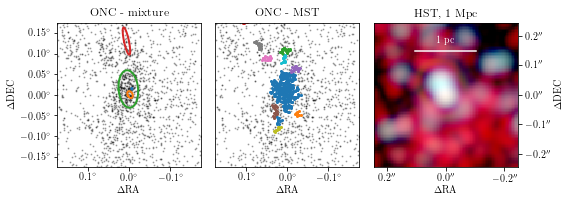

In [9]:
# Make final plot
plt.figure(1, figsize=(8,2.8))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# First panel: star positions plus Kuhn decomposition
plt.subplot(131)
plt.plot(ra_off, dec_off, 'ko', ms=1, alpha=0.25)

# Overplot Kuhn ellipses
#for r, d, a, b, p in zip(ra_kuhn_off, dec_kuhn_off, rc_maj_d, rc_min_d, phi):
for r, d, a, b, p in zip(ra_kuhn_off, dec_kuhn_off, rc_maj, rc_min, phi):
    th = 2.0*np.pi*np.linspace(0,1)
    x1 = b*np.cos(th) * 180/np.pi * (1/dist_onc) / np.cos((d+dec_th1c)*np.pi/180.)
    y1 = a*np.sin(th) * 180/np.pi * (1/dist_onc)
    x = r + np.cos(-p.to(u.radian))*x1 - np.sin(-p.to(u.radian))*y1
    y = d + np.sin(-p.to(u.radian))*x1 + np.cos(-p.to(u.radian))*y1
    plt.plot(x, y, lw=2, zorder=5)

# Adjust and label axes
axlim = np.array([-fov.to('degree').value/2,
                  fov.to('degree').value/2])   # Plot range in degree
plt.axis('equal')
plt.xlim(axlim[::-1])
plt.ylim(axlim)
plt.gca().xaxis.set_major_formatter(StrMethodFormatter("${x:.1f}^\circ$"))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter("${x:.2f}^\circ$"))
plt.xlabel('$\Delta$RA')
plt.ylabel('$\Delta$DEC')
plt.gca().set_aspect('equal', adjustable='box')
plt.title('ONC - mixture')

# Second panel: star positions plus two decompositions
plt.subplot(132)
plt.plot(ra_off, dec_off, 'ko', ms=1, alpha=0.25)

# Overplot MST groups
for i, mg in enumerate(mst_groups):
    plt.plot(ra_off[mg['stars']], dec_off[mg['stars']],
             'o', color='C{:d}'.format(i % 10),
             ms=2)
    
# Adjust and label axes; note that we are cheating a
# tiny bit by making the axes equal, when we should
# in principle divide the RA direction by cos(DEC) to
# make the plot a true square. However, the ONC is so
# close to equatorial that the distortion is < 1%, so
# we're just going to be lazy and not worry about it
plt.axis('equal')
plt.xlim(axlim[::-1])
plt.ylim(axlim)
plt.xlabel('$\Delta$RA')
plt.gca().xaxis.set_major_formatter(StrMethodFormatter("${x:.1f}^\circ$"))
plt.gca().set_yticks([])
plt.gca().set_aspect('equal', adjustable='box')
plt.title('ONC - MST')

# Third panel: image at lage distance
plt.subplot(133)
plt.imshow(ubv_img[:,::-1,:], origin='lower', aspect='equal',
           extent=[mpc_off[-1].to('arcsec').value, mpc_off[0].to('arcsec').value,
                   mpc_off[0].to('arcsec').value, mpc_off[-1].to('arcsec').value])
plt.gca().yaxis.tick_right()
plt.gca().yaxis.set_label_position('right')
plt.gca().xaxis.set_major_formatter(StrMethodFormatter("${x:.1f}^{{\prime\prime}}$"))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter("${x:.1f}^{{\prime\prime}}$"))
plt.xlabel('$\Delta$RA')
plt.ylabel('$\Delta$DEC')
plt.title('HST, 1 Mpc')

# Add scale bar
plt.plot([-0.5*(u.pc/dist_img*u.rad).to('arcsec').value,
          0.5*(u.pc/dist_img*u.rad).to('arcsec').value],
         [0.15, 0.15], 'w')
plt.text(0, 0.17, '1 pc', 
         ha='center', va='bottom', color='w')

# Adjust spacing
plt.subplots_adjust(wspace=0.1, left=0.1, bottom=0.12, top=0.95)

# Save
plt.savefig(osp.join('figures', 'orion_plot.pdf'))

In [10]:
# Read Kounkel+ 2018 catalog of positions and ages
kdata = asc.read(osp.join('data', 'kounkel2018.txt'))

In [11]:
# Construct a composite age quantity from Kounkel's catalog,
# and clean the catalog of entries where a meaningful age is
# not available.
age = np.copy(kdata['age_hr'])
age_hr = np.ones(len(age), dtype=bool)
idx = np.logical_not(np.nan_to_num(age) > 1e-2)
age[idx] = kdata['age_cmd'][idx]
age_hr[idx] = False
idx = np.nan_to_num(age) > 0
ra = kdata['ra'][idx]
dec = kdata['dec'][idx]
group = kdata['cloud'][idx]
age = age[idx]
age_hr = age_hr[idx]

In [12]:
# Use kernel density estimation to construct estimates of
# the density of stars in the Orion A and Orion D regions
pos_ori_A = np.vstack((ra[group == 1], dec[group == 1]))
kde_ori_A = gaussian_kde(pos_ori_A)
pos_ori_D = np.vstack((ra[group == 4], dec[group == 4]))
kde_ori_D = gaussian_kde(pos_ori_D)

# Use KDE to get density on grid
xlim=[88,77]
ylim=[-12,6]
ngrd = 100
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], ngrd),
                     np.linspace(ylim[0], ylim[1], ngrd))
meshpos = np.vstack((xx.ravel(), yy.ravel()))
den_ori_A = np.reshape(kde_ori_A(meshpos).T, xx.shape)
den_ori_D = np.reshape(kde_ori_D(meshpos).T, xx.shape)

t50 = 1.744500, t50 / tff = 3.007759
t90 = 6.339000, t90 / tff = 10.929310


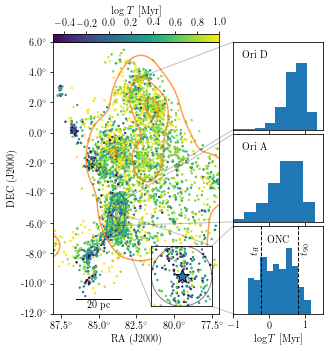

In [13]:
# Create age plot
fig=plt.figure(figsize=(5,5))
plt.clf()

# Limits
xlim=[88,77]
ylim=[-12,6]
agenorm = norm(-0.5,1)

# Make main panel
ax = plt.subplot2grid((3, 3), (0, 0), rowspan=3, colspan=2)

# Adjust axes and limits
fig.subplots_adjust(wspace=0.05, hspace=0.05)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_aspect('equal')

# Add labels
plt.ylabel('DEC (J2000)')
plt.xlabel('RA (J2000)')
ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.1f}$^\circ$"))
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.1f}$^\circ$"))

# Make plot of stellar ages
scat = plt.scatter(ra, dec, c=np.log10(age), norm=agenorm, s=2)

# Add scale bar
xsc = 85
ysc = -11
dxsc_phys = 20*u.pc
dxsc = (dxsc_phys/dist_onc * 180/np.pi) / np.cos(ysc*np.pi/180.)
ax.plot([xsc-dxsc/2, xsc+dxsc/2], [ysc, ysc],
        'k', lw=1)
ax.text(xsc, ysc-0.1, '20 pc', 
        horizontalalignment='center',
        verticalalignment='top')

# Add contours showing locations of Ori A and D
clev = [0.1, 0.5, 0.9]
qset_ori_A = ax.contour(xx, yy, den_ori_A/np.amax(den_ori_A),
                        levels=clev, alpha=0.75,
                        colors='C0')
qset_ori_D = ax.contour(xx, yy, den_ori_D/np.amax(den_ori_D),
                        levels=clev, alpha=0.75,
                        colors='C1')

# Add circle to define the ONC; should techincally be an ellipse, but
# we're so close to equatorial that we're not going to worry about the
# ~1% ellipticity, particularly since this is comparable to the error
# induced by the distance uncertainty
r_onc_phys = 1*u.pc
r_onc = (r_onc_phys/dist_onc).to('') * 180/np.pi
phi = np.linspace(0,2*np.pi,100)
ax.plot(ra_th1c + r_onc*np.cos(phi),
        dec_th1c + r_onc*np.sin(phi), 'w', lw=1)

# Add inset around ONC
fig.canvas.draw() # Force drawing here to get the right transform
bb_data = Bbox.from_bounds(81.5, -12, -4, 5)
disp_coords = ax.transData.transform(bb_data)
fig_coords = fig.transFigure.inverted().transform(disp_coords)
axinset = fig.add_axes(Bbox(fig_coords))

# Draw stars in inset; only include those with HR-based ages
idx = age_hr
axinset.scatter(ra[idx] - ra_th1c, dec[idx] - dec_th1c, 
                c=np.log10(age[idx]), norm=agenorm,
                s=2)
axinset.plot(r_onc*np.cos(phi), r_onc*np.sin(phi), 'k', lw=1, alpha=0.5)
axinset.plot([0], [0], '*', ms=14, mec='k', mfc='C0')

# Adjust inset axes and labels
axinset.set_xlim(np.array([r_onc, -r_onc]))
axinset.set_ylim(np.array([-r_onc, r_onc]))
axinset.set_aspect('equal')
axinset.set_xticks([])
axinset.set_yticks([])

# Draw zoom-in lines from the box in the main panel to the inset
fig.canvas.draw() # Force drawing here to get the right transform
lower_left_disp = axinset.transData.transform([r_onc, -r_onc])
lower_left_data = ax.transData.inverted().transform(lower_left_disp)
top_right_disp = axinset.transData.transform([-r_onc, r_onc])
top_right_data = ax.transData.inverted().transform(top_right_disp)
ax.plot([ra_th1c + r_onc/np.sqrt(2), lower_left_data[0]],
        [dec_th1c - r_onc/np.sqrt(2), lower_left_data[1]],
        'k', lw=1, alpha=0.25)
ax.plot([ra_th1c - r_onc/np.sqrt(2), top_right_data[0]],
        [dec_th1c + r_onc/np.sqrt(2), top_right_data[1]],
        'k', lw=1, alpha=0.25)

# Now add age histograms for different regions: Orion D
axhist1 = plt.subplot2grid((3, 3), (0, 2), rowspan=1, colspan=1)
idx = group == 4
try:
    # Depends on matplotlib version
    count, edges, patches = axhist1.hist(np.log10(age[idx]), density=True)
except:
    axhist1.clear()
    count, edges, patches = axhist1.hist(np.log10(age[idx]), normed=True)
axhist1.text(-0.75, 0.9*1.75, 'Ori D',
             verticalalignment='top',
             horizontalalignment='left')
axhist1.set_xlim([-1,1.5])
axhist1.set_ylim([0,1.75])
axhist1.set_xticklabels([])
axhist1.set_yticks([])

# Orion A
idx = group == 1
axhist2 = plt.subplot2grid((3, 3), (1, 2), rowspan=1, colspan=1)
try:
    count, edges, patches = axhist2.hist(np.log10(age[idx]), density=True)
except:
    axhist2.clear()
    count, edges, patches = axhist2.hist(np.log10(age[idx]), normed=True)
axhist2.text(-0.75, 0.9*1.25, 'Ori A',
             verticalalignment='top',
             horizontalalignment='left')
axhist2.set_xlim([-1,1.5])
axhist2.set_ylim([0,1.25])
axhist2.set_xticklabels([])
axhist2.set_yticks([])

# ONC
idx = np.logical_and.reduce(
    (group == 1,
     np.sqrt((ra - ra_th1c)**2 + (dec - dec_th1c)**2) < r_onc,
     age_hr))
axhist3 = plt.subplot2grid((3, 3), (2, 2), rowspan=1, colspan=1)
try:
    count, edges, patches = axhist3.hist(np.log10(age[idx]), density=True)
except:
    axhist3.clear()
    count, edges, patches = axhist3.hist(np.log10(age[idx]), normed=True)
axhist3.plot(np.log10(np.array([0.58,0.58])), [0,1.2],    
             'k--', lw=1)
axhist3.text(np.log10(0.58), 0.8, r'$t_{\mathrm{ff}}$',
             horizontalalignment='right', 
             verticalalignment='bottom',
             rotation=90)
age_tmp = np.sort(np.copy(age[idx]))
age90 = age_tmp[int(np.round(0.90*len(age_tmp)))]
age50 = age_tmp[int(np.round(0.50*len(age_tmp)))]
print("t50 = {:f}, t50 / tff = {:f}".format(age50, age50/0.58))
print("t90 = {:f}, t90 / tff = {:f}".format(age90, age90/0.58))
axhist3.plot(np.log10(age90)*np.ones(2), [0,1.2],    
             'k--', lw=1)
axhist3.text(np.log10(age90*1.2), 0.8, r'$t_{90}$',
             horizontalalignment='left', 
             verticalalignment='bottom', rotation=90)
axhist3.text(0.25, 0.9*1.2, 'ONC',
             verticalalignment='top',
             horizontalalignment='center')
axhist3.set_xlim([-1,1.5])
axhist3.set_yticks([])
axhist3.set_ylim([0,1.2])
axhist3.set_xlabel(r'$\log T$ [Myr]')

# Make callout lines from contours to histograms
fig.canvas.draw() # Force drawing here to get the right transform

# Ori D
lower_left_disp = axhist1.transData.transform([-1, 0])
lower_left_data = ax.transData.inverted().transform(lower_left_disp)
top_left_disp = axhist1.transData.transform([-1, 1.75])
top_left_data = ax.transData.inverted().transform(top_left_disp)
idxmin = np.argmin(qset_ori_D.allsegs[1][0][:,1])
idxmax = np.argmax(qset_ori_D.allsegs[1][0][:,1])
ax.plot([qset_ori_D.allsegs[1][0][idxmin,0], lower_left_data[0]],
        [qset_ori_D.allsegs[1][0][idxmin,1], lower_left_data[1]],
        'k', lw=1, clip_on=False, alpha=0.25)
ax.plot([qset_ori_D.allsegs[1][0][idxmax,0], top_left_data[0]],
        [qset_ori_D.allsegs[1][0][idxmax,1], top_left_data[1]],
        'k', lw=1, clip_on=False, alpha=0.25)

# Ori A
lower_left_disp = axhist2.transData.transform([-1, 0])
lower_left_data = ax.transData.inverted().transform(lower_left_disp)
top_left_disp = axhist2.transData.transform([-1, 1.25])
top_left_data = ax.transData.inverted().transform(top_left_disp)
idxmin = np.argmin(qset_ori_A.allsegs[1][0][:,1])
idxmax = np.argmax(qset_ori_A.allsegs[1][0][:,1])
ax.plot([qset_ori_A.allsegs[1][0][idxmin,0], lower_left_data[0]],
        [qset_ori_A.allsegs[1][0][idxmin,1], lower_left_data[1]],
        'k', lw=1, clip_on=False, alpha=0.25)
ax.plot([qset_ori_A.allsegs[1][0][idxmax,0], top_left_data[0]],
        [qset_ori_A.allsegs[1][0][idxmax,1], top_left_data[1]],
        'k', lw=1, clip_on=False, alpha=0.25)

# ONC
lower_left_disp = axhist3.transData.transform([-1, 0])
lower_left_data = ax.transData.inverted().transform(lower_left_disp)
top_left_disp = axhist3.transData.transform([-1, 1.2])
top_left_data = ax.transData.inverted().transform(top_left_disp)
lower_right_inset_disp = axinset.transData.transform([-r_onc, -r_onc])
lower_right_inset_data = ax.transData.inverted().transform(lower_right_inset_disp)
top_right_inset_disp = axinset.transData.transform([-r_onc, r_onc])
top_right_inset_data = ax.transData.inverted().transform(top_right_inset_disp)
ax.plot([lower_right_inset_data[0], lower_left_data[0]],
        [lower_right_inset_data[1], lower_left_data[1]],
        'k', lw=1, clip_on=False, alpha=0.25)
ax.plot([top_right_inset_data[0], top_left_data[0]],
        [top_right_inset_data[1], top_left_data[1]],
        'k', lw=1, clip_on=False, alpha=0.25)

# Add top colorbar
fig.canvas.draw() # Force drawing here to get the right transform
bb_data = Bbox.from_bounds(xlim[0], ylim[1], xlim[1]-xlim[0], 0.03*(ylim[1]-ylim[0]))
disp_coords = ax.transData.transform(bb_data)
fig_coords = fig.transFigure.inverted().transform(disp_coords)
cax = fig.add_axes(Bbox(fig_coords))
cbar.Colorbar(cax, scat, orientation='horizontal')
cax.xaxis.set_label_position('top')
cax.xaxis.set_ticks_position('top')
cax.set_xlabel(r'$\log\,T$ [Myr]')

# Save
plt.savefig(osp.join('figures', 'orion_age.pdf'))